Creator: Ryan Corbyn
Date created: 12/10/2020

Edited:     Name         Date      Reason

Ryan Corbyn  13/10/2020

Ryan Corbyn  30/10/2020 - Correct the 11 point selection process so that it is based on fluorescence intenstiy and not frequency position. 

This is a program that is designed to load in data from a full CW ODMR measurement. 

From here, the line scans are averaged to give the mean ODMR spectra, this is then plotted as a scatter graph and a double lorentzian line shape is fitted to the data. 

The fitting parameters are saved to a data file, along with the plot. 

Finally, the Double lorentzian lineshape fitting is used to generate an 11 point frequnecy sweep that can be used for both temeprature sensing and magentic field sensing. 

In [1]:
import scipy.optimize as opt 
import numpy as np 
import matplotlib.pyplot as plot 
import os 
import pandas as pd

In [2]:
def load_data(file_path): 
    # load the ODMR data file in to an np array 
    data_array = np.loadtxt(file_path)
    
    return(data_array)

In [3]:
def load_params(file_path):
    # load in the params data. 
    params_data = pd.read_table(file_path, names = ['Parameter name', 'Parameter value']) 
    return(params_data)

In [4]:
def create_freq_scan(start, stop, step_size):
    # takes the scan parameters from the params data file. 
    step_size_GHz = step_size/1000
    number_of_steps = int((stop-start)/step_size_GHz)+1
    freq = np.linspace(start, stop, number_of_steps)
    
    return(freq)

In [5]:
def set_plot_params():
    # formats the plot parameters 
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})

In [6]:
def plot_heat_map(freq, odmr_data, dwell_time):
    # plot the full ODMR data as a heatmap. 
    number_of_scans = len(odmr_data)
    Y = np.linspace(1, number_of_scans, number_of_scans) 
    
    fig1, ax1 = plot.subplots()
    
    hm = ax1.pcolormesh(freq, Y, odmr_data, cmap = 'viridis')
    fig1.colorbar(hm, label = '\ncounts per ' + str(dwell_time) + r' $\mu$s')
    ax1.set_xlim(np.min(freq),np.max(freq))
    ax1.set_xticks(np.arange(np.min(freq), np.max(freq), 0.05))
    ax1.set_xlabel('Microwave Frequency (GHz)')
    ax1.set_ylabel('Number of scans')
    
    return(fig1, ax1)

In [7]:
def mean_data(odmr_data):
    # find the mean data 
    mean_odmr_data =  np.mean(odmr_data, axis=0)
    return(mean_odmr_data)

In [8]:
def normalise_data(mean_odmr_data):
    # normalise the data to the maximum value of the mean dataset. 
    norm_odmr_data = mean_odmr_data/(np.max(mean_odmr_data))
    return(norm_odmr_data)

In [9]:
def scatter_plot(freq,mean_data):
    # Creates a scatter plot for experimental data and plot parameters. 
    fig2, ax2 = plot.subplots()
    plot.rcParams.update({'font.size' : 16})
    plot.rcParams.update({'figure.figsize' :[12, 8]})
    ax2.scatter(freq, mean_data, marker = 'x',color = 'r', label = "ODMR Data")
    ax2.set_xlim(np.min(freq),np.max(freq))
    return(fig2, ax2)

In [10]:
def get_init_params(odmr_data, freq):
    # find the minima of the ODMR spectra and ODMR dip contrast and 
    # flourenscent baseline.
    half_data_length = int((len(freq)-1)/2)
    
    #find the indices for the lowest frequency value
    low_freq_min_index = np.where(odmr_data[0:half_data_length] == np.min(odmr_data[0:half_data_length]))
    high_freq_min_index = np.where(odmr_data[half_data_length:len(odmr_data)-1] == 
                                   np.min(odmr_data[half_data_length:len(odmr_data)-1]))
   
    # frequencies corresponding to ODMR minima
    freq_mins = [np.float(freq[low_freq_min_index[0]]),
                 np.float(freq[high_freq_min_index[0]+half_data_length])]
    
    # manually set frequencies. 
    
    #freq_mins = [2.78, 2.96]
    
    flourescent_baseline = np.mean(odmr_data)
    
    # approximate contrast for ODMR peaks
    contrast = [np.float((1-odmr_data[low_freq_min_index[0]]/flourescent_baseline)), 
                np.float((1-odmr_data[high_freq_min_index[0]+half_data_length]/flourescent_baseline))]

    return(freq_mins, contrast, flourescent_baseline)

In [11]:
def optimised_lorentz_fit(freq, mean_data, init_params, lower_bounds, upper_bounds):
    # A method to find the fitting prameters for the ODMR dataset. 
    y_error = np.sqrt(mean_data) # poissonian noise
    coeffs, confidence = opt.curve_fit(double_lorentz, freq, mean_data, init_params, 
                                       sigma = y_error, bounds = (lower_bounds, upper_bounds))
    opt_error = np.sqrt(np.diag(confidence))
    
    return(coeffs, opt_error)

In [12]:
def double_lorentz(x, A1, X01, sig1, A2, X02, sig2, offset): #P0[0], P0[1], P0[2], P0[3], P0[4], P0[5], P0[6]):
    # A1 = Amplitude 1, X01 = Resonance 1, sig1 = FWHM 1
    # A2 = Amplitude 2, X02 = Resonance 2, sig2 = FWHM 2, offset = offset
    
    first_peak = (A1/np.pi)*((sig1**2)/(sig1**2 +(2*x-2*X01)**2))
    second_peak = (A2/np.pi)*((sig2**2)/(sig2**2 +(2*x-2*X02)**2))
    
    return (first_peak + second_peak + offset)

In [13]:
def plot_fitting(ax2, freq, y_fit):
    # plot the y fit. 
    
    ax2.plot(freq, y_fit, color='k', label='Double Lorentz \nfitting')
    ax2.legend()
    ax2.set_xlabel('Microwave Frequency (GHz)')
    ax2.set_ylabel('Normalised Counts')
    
    return(ax2)
 

In [14]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [15]:
def save_data(date, file_ID, contrast, coeffs, opt_error, r_squared, fig1, fig2):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\Thermometry\\' + date + '\\'
    output_data_file = destination_folder + date + '_NVScan_analysis.dat'
    
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
        # Checking the output file exists and creating and initialising it if not
    
    if os.path.isfile(output_data_file) == False:
        with open(output_data_file, "w") as wf:
            wf.write('File name' +  ', \t' + 
                     'Resonant frequency 1 (GHz)' + '\t' + 'Error Resonant frequency 1 (GHz)' + '\t' + 
                     'Resonant frequency 1 contrast (%)' + '\t' + 
                     'FWHM 1 (MHz)' + '\t' + 'FWHM 1 error (MHz)' + '\t' + 
                     'Resonant frequency 2 (GHz)' + '\t' + 'Error Resonant frequency 2 (GHz)' + '\t' + 
                     'Resonant frequency2 contrast (%)' + '\t' + 
                     'FWHM 2 (MHz)' + '\t' + 'FWHM 2 error (MHz)' + '\t' + 
                     'Off Res Fluorescence intensity (per dwell time)' + '\t' +'R^2 for fitting' +'\n')
    # Writing contrast dip description to the .dat file
    
    with open(output_data_file, "a") as wf:
        wf.write(file_ID + ' \t' +  
                 str(coeffs[1]) + " \t"  + str(opt_error[1]) + " \t" + 
                 str(contrast[0]*100) + " \t"  +  
                 str(abs(coeffs[2])*1000) + " \t" + str(opt_error[2]*1000) + " \t" + 
                 str(coeffs[4]) + " \t"  + str(opt_error[4]) + " \t" + 
                 str(contrast[1]*100) + " \t" +
                 str(abs(coeffs[5])*1000) + " \t" + str(opt_error[5]*1000) + " \t" + 
                 str(coeffs[6]) + " \t" +str(r_squared) + '\n')
        
    # Saving a plot of the raw data to a folder. 
    fig1.savefig(destination_folder + file_ID + '_heatmap.pdf', transparent = True)    
    fig1.savefig(destination_folder + file_ID + '_heatmap.png', transparent = True) 
    
    fig2.savefig(destination_folder + file_ID + '.pdf', transparent = True)    
    fig2.savefig(destination_folder + file_ID + '.png', transparent = True) 
    

0.9839214077621662
[0.0661713656580365, 0.06235995094111069]
[2.864, 2.875]


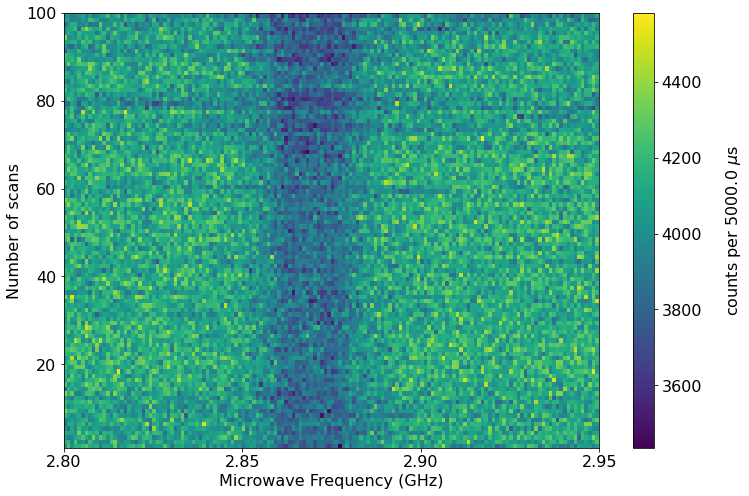

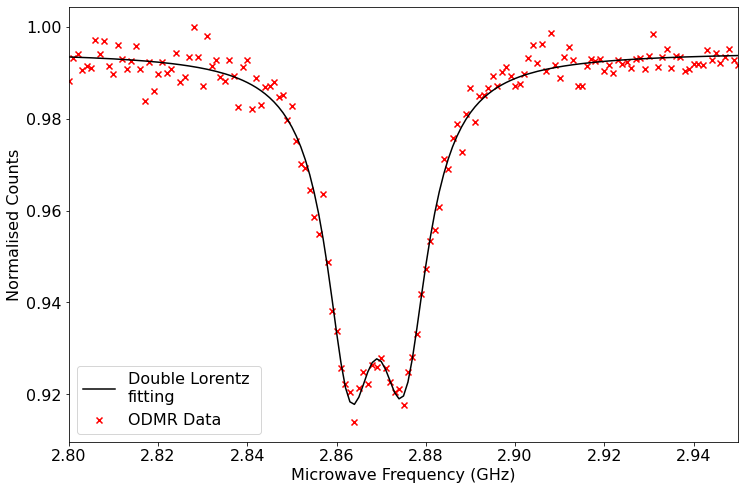

In [17]:
#######
 # This portion of the code produced the ODMR data plotting and the double lorentz fitting and 
 # Saves this data into a text file and the 2 plots generated. 
#######

# Load in the data file into an np array, and freqeuncy scan parameters 
# into a pandas array.
folder_path = 'I:\\Science\\Physics-Nanobiophotonics\\Group\\User Data\\ODMR\\ODMR and Imaging\\'
date = '20210325'
file_name = date + '_NVScan_08'

odmr_data = load_data(folder_path + date + '\\' + file_name + '.dat')
params_file = load_params(folder_path + date + '\\' + file_name + 'Params.dat')
params_values = params_file['Parameter value']

# Create the freqeuncy scan array. 
freq = create_freq_scan(params_values[0], params_values[1], params_values[2])

# plot a colour map of the ODMR data and set plot format for the program. 
set_plot_params()
fig1, ax1 = plot_heat_map(freq, odmr_data, params_values[3])

# find the mean of the ODMR data
mean_odmr_data = mean_data(odmr_data)
# Normalise the dataset
norm_mean_odmr = normalise_data(mean_odmr_data)

# scatter plot of data
fig2, ax2 = scatter_plot(freq, norm_mean_odmr)

# find the freqeuncy points with the highest ODMR contrast
freq_mins, contrast, flourescent_baseline = get_init_params(norm_mean_odmr, freq)

# create the initial parameters for ODMR double lorentzian 
# line fitting
#init_params = [contrast[0], freq_mins[0], 0.001, contrast[1], freq_mins[1], 0.001, flourescent_baseline]
init_params = [contrast[0], 2.865, 0.001, contrast[1], 2.87, 0.001, flourescent_baseline]

lower_bounds = [-np.inf, init_params[1] - 0.01, 0, -np.inf, init_params[4] - 0.01, 0, 0]
upper_bounds = [np.inf, init_params[1] + 0.01, 1, np.inf, init_params[4] + 0.01, 1, np.inf]

# generate the optimised curve fit parameters. 
fitting_params, error_in_fit = optimised_lorentz_fit(freq, norm_mean_odmr, 
                                                     init_params, lower_bounds, upper_bounds)

# create the double lorentz fit array
y_fit = double_lorentz(freq, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])

# plot the fitting to ax2
ax2 = plot_fitting(ax2, freq, y_fit)

# Find the FWHM for the curve fitting. 
#fwhm = get_FWHM(freq, y_fit, freq_mins, fitting_params[6], params_values[2])
    
# get the r^2 value for the fitting 
r_squared = get_r_squared(freq, norm_mean_odmr, y_fit)
print(r_squared)
print(contrast)
print(freq_mins)
#save_data(date, file_name, contrast, fitting_params, error_in_fit, r_squared, fig1, fig2)

In [33]:
def find_straight_lines(y_fit, res_freqs, freq):
    # A method to find the stright portion of the ODMR fittings. 
    positions = []
    # find the index of the ODMR minima
    # These are used to split the OMDR spectra up into 4 parts to find the 
    # 4 linear sections of the graph. 
    positions.append(0)
    positions.append(int( np.where(freq == res_freqs[0])[0] ))
    positions.append(int( np.where(freq == (res_freqs[1]+res_freqs[0])/2)[0]))
    positions.append(int( np.where(freq == res_freqs[1])[0] ))
    positions.append(len(freq)-1)
    minima_limit = np.zeros([2,1])
    
    # Set the bounds for the stright-line fittings. 
    minima_limit[0,0] = 1.005*y_fit[positions[1]]
    minima_limit[1,0] = 1.005*y_fit[positions[3]]
    maxima_limit = 0.97*np.mean(y_fit)
    
    a = 0
    df = pd.DataFrame(columns=["0", "1", "2", "3"])
    x=[]
    #print(positions)
    # Find the positions of the y values that forfill the stright-line criteria. 
    for i in range(len(positions)-1):
        for j in range(positions[i+1]-positions[i]):
            
            if y_fit[positions[i]+j] >= minima_limit[a,0] and y_fit[positions[i]+j] <= maxima_limit:
                x.append(positions[i]+j)
        
        df[str(i)] = pd.Series(x)
        x = [] 
        if i == 1:
            a = 1
            
    return(df)

In [19]:
def straight_line_fit(x, m, c):
    # creates a staight line fit 
    y = m*x + c
    return(y)

In [20]:
def find_linear_fits(df, freq, y_fit):
    # finds the linear fits and plots them and finds the r2 values for each 
    # df = data frame of indicies corresponding to the linear portion of the graph.
    
    #initalises local variables
    init_params = [1,1]
    fit_params = np.zeros([len(df.columns), 2])
    fit_errors = np.zeros([len(df.columns), 2])
    linear_fit_freqs = pd.DataFrame()
    linear_fit_lorentz_values = pd.DataFrame() 
    fig4, ax4 = plot.subplots()
    
    # plot lorentz fitting
    ax4.plot(freq, y_fit, color = 'k', label='Lorentz fitting')
    
    # a loop to generate the straight line fits for the ODMR dips. 
    # Also finds the 4 frequency points usedd for each curve for 
    # thermometry and the r_squared values for the linear fits. 
    for i in range(len(df.columns)):
        # indicies corresponding to the linear portions of the 
        # lorentz fittings.
        indicies = np.array(df[str(i)])
        indicies = indicies[~np.isnan(indicies)].astype(int)
        # Preform linear fit
        fit, confidence = opt.curve_fit(straight_line_fit, freq[indicies], y_fit[indicies], init_params)
        fit_errors[i,:] = np.sqrt(np.diag(confidence))
        fit_params[i,:] = fit
        linear_fit_freqs[str(i)] = pd.Series(freq[indicies])
        linear_fit_lorentz_values[str(i)] = pd.Series(y_fit[indicies])
    
    return(fig4, ax4, fit_params, fit_errors, linear_fit_freqs, linear_fit_lorentz_values)

In [21]:
def generate_linear_fits(fit_params, linear_fit_freqs, linear_fit_lorentz_values, ax4):        
    #create linear fit and plot
    
    y_linear_fit = pd.DataFrame()
    r_squared = []
    
    for i in range(fit_params.shape[0]):
        y = straight_line_fit(linear_fit_freqs[str(i)], fit_params[i][0], fit_params[i][1])
        ax4.plot(linear_fit_freqs[str(i)], y, linewidth = 2, color = 'r')
        
        y_linear_fit[str(i)] = pd.Series(y)
        # find the r_squared value for the linear fit. 
        r_squared.append(get_r_squared(linear_fit_freqs[str(i)], linear_fit_lorentz_values[str(i)], y))
    
    ax4.plot(linear_fit_freqs[str(i)], y, linewidth = 2, label='Linear Fit',
                color = 'r')
    
    ax4.set_xlabel('Microwave Frequency (GHz)')
    ax4.set_ylabel('Normalised Counts')
   

    return(y_linear_fit, ax4, r_squared)

In [22]:
def find_first_two_freq_points(linear_fit):
    # This method finds the first two frequency points to be used 
    # for the 11 point thermometry experiments. 
    
    array_length = len(linear_fit)
    
    mid_point = np.floor(array_length/2) 
    delta_f_index = np.floor(array_length/6) 
    
    f_minus = int(mid_point-delta_f_index)
    f_plus = int(mid_point+delta_f_index)
    f_mid = int(mid_point)
    
    return(f_mid,[ f_minus, f_plus])

In [23]:
def get_4_measurement_frequencies(linear_fit, linear_freq_arrays, reference_intensity, delta_f, fig3, ax3):
    # This is the method to find the index in the lienar fits for the
    # 4 frequency points to be used for 4 point thermometry. 
    
    thermometry_freqs = pd.DataFrame()

    for i in range(linear_fit.shape[1]):
        result_index = linear_fit[str(i)].sub(reference_intensity).abs().idxmin()
        # The above finds the index in each of the linear fits which is closest to the reference intensity  
        # determined for the first linear fitting in the ODMR spectra. 
        index_plus_delta_f = result_index + delta_f
        index_minus_delta_f  = result_index - delta_f
        measurement_freqs = [linear_freq_arrays[str(i)][index_minus_delta_f], linear_freq_arrays[str(i)][index_plus_delta_f]]
        I_vals = [linear_fit[str(i)][index_minus_delta_f], linear_fit[str(i)][index_plus_delta_f]]
        print(I_vals)
        thermometry_freqs[str(i)] = pd.Series(measurement_freqs)
        
        ax3.scatter(measurement_freqs, I_vals, color = 'k', linewidth = '2', marker = 'x')
    
    ax3.scatter(measurement_freqs, I_vals, color = 'k', linewidth = '2', marker = 'x',
                   label = '8 Dip measurment points')
    
    ax3.legend()
    
    return(fig3, ax3, thermometry_freqs)
    

In [24]:
def get_r_squared(x, y_data, y_fitting):
    # This is a function used to generate the goodness of fit metric r^2.
    # This value will be used to judge the effectiveness of the curve fitting 
    # used to find the resonant frequencies of the NV centre.
    
    y_data_mean = np.mean(y_data)
    SStot = np.sum((y_data - y_data_mean)**2) # Find the variation in experimental y values.
    SSres = np.sum((y_data - y_fitting)**2) # Find the variation betweem the experimental and fitted y values. 
    
    r_squared = 1 - (SSres/SStot) # Calculate R^2
    
    return(r_squared)

In [25]:
def save_11_point_fitting_data(date, file_ID, linear_fit_params, linear_fit_error, r_squared_linear, fig):
    
    destination_folder = 'H:\\My Documents\\Strathclyde_Back_up\\Graphs_and_analysis\\Thermometry\\' + date + '\\'
    output_data_file = destination_folder + '11 point thermometry fitting ' + file_ID +  '.dat'
    # Checking to see if the folder exists in which to save the data, and creating it if it does not
    if not os.path.exists(destination_folder):
        os.makedirs(destination_folder)
    
    if not os.path.exists(output_data_file):
        with open(output_data_file, "w") as wf:
            wf.write('11 point thermometry initial data' + '\n' + 
                     'linear fit number' + '\t' + 'Gradient (counts per GHz)' + '\t' + 'Error in Gradient (counts per GHz)' + '\t' +
                     'Intercept (counts)' + '\t' + 'Error in Intercept (counts per GHz)' + '\t' +
                     'R Sqaured' + '\n') 
            
    print(r_squared)
            
    for i in range(len(linear_fit_error)):
        with open(output_data_file, "a") as wf:
            wf.write('Linear fit ' + str(i+1) + '\t' + 
                        str(linear_fit_params[i,0])  + '\t' + str(linear_fit_error[i,0])  + '\t' +
                        str(linear_fit_params[i,1])  + '\t' + str(linear_fit_error[i,1])  + '\t' +
                        str(r_squared_linear[i])  + '\n')
            
        
    fig.savefig(destination_folder + '11 point thermometry fitting ' + file_ID  + '.pdf', transparent = True)
    fig.savefig(destination_folder + '11 point thermometry fitting ' + file_ID  + '.png', transparent = True)
    

In [26]:
def create_generator_list(thermometry_freqs, folder_path, date, file_name):
    # Creates a text file containing the 11 frequnecies in Hz that 
    # can be transferred to the microwave generator. 
    
    frequencies = [2.75, thermometry_freqs['0'][0], thermometry_freqs['0'][1],
                  thermometry_freqs['1'][0], thermometry_freqs['1'][1], 2.87, 
                  thermometry_freqs['2'][0], thermometry_freqs['2'][1],
                  thermometry_freqs['3'][0], thermometry_freqs['3'][1], 3.00]
    
    frequencies_Hz = np.array(frequencies)*np.power(10,9)

    save_path = folder_path + date + '\\' + date + '_11 thermometery_points_' + file_name+  '.txt'
    
    for i in range(len(frequencies)):
        with open(save_path, "a") as wf:
            wf.write(str(int(frequencies_Hz[i])) + '\t' + '15.0' + '\n')
    

In [34]:
#######
 # This portion of the code produced the linear fitting used to determine the frequency points 
    # to be used for 11 point thermometry. 
    # The fit data is saved into a folder on the H drive. 
    # The 11 points for thermometry are saved to a .dat file within the User Data folder on the iDrive. 
#######

# Create a higher resolution frequency and lorentz fitting. 
# This will allow better determination of the freqeuncies to be used for 
# 11 point thermometery. 

high_res_step = (len(freq)-1)*1000 + 1

freq_high_res = np.linspace(freq[0], freq[len(freq)-1], high_res_step)
high_res_y_fit = double_lorentz(freq_high_res, fitting_params[0], fitting_params[1], fitting_params[2], 
                  fitting_params[3], fitting_params[4], fitting_params[5], fitting_params[6])

linear_ODMR = find_straight_lines(high_res_y_fit, [round(fitting_params[1],3), round(fitting_params[4],3)], freq_high_res)

fig3, ax3, linear_fit_params, linear_fit_error,  linear_fit_freqs, linear_fit_lorentz_values = find_linear_fits(linear_ODMR, freq_high_res, high_res_y_fit)

y_linear_fits, ax3, r_squared_linear = generate_linear_fits(linear_fit_params, linear_fit_freqs, linear_fit_lorentz_values, ax3)

f1_mid_index, thermometry_freqs_index = find_first_two_freq_points(y_linear_fits['0'])

reference_intensity = linear_fit_lorentz_values['0'][f1_mid_index]
delta_f = int((thermometry_freqs_index[1] - thermometry_freqs_index[0])/2)

fig3, ax3, thermometry_freqs = get_8_measurement_frequencies(y_linear_fits, linear_fit_freqs, reference_intensity, delta_f, fig3,  ax3)

#save_11_point_fitting_data(date, file_name, linear_fit_params, linear_fit_error, r_squared_linear, fig3)
create_generator_list(thermometry_freqs, folder_path, date, file_name)

IndexError: list index out of range

In [47]:
print(y_linear_fits, linear_fit_freqs, reference_intensity, delta_f)

NameError: name 'y_linear_fits' is not defined

In [186]:
create_generator_list(thermometry_freqs, folder_path, date, file_name)

2.83902
[2.750000e+09 2.839020e+09 2.840124e+09 2.846580e+09 2.847684e+09
 2.870000e+09 2.913797e+09 2.914901e+09 2.919182e+09 2.920286e+09
 3.000000e+09]


In [32]:
print(linear_ODMR.shape)

(8414, 4)


ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [45]:
print(test)

[10]
